In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import warnings
from nlp_tools import text_processing, data_analysis
import subject_verb_object_extract as svo_extract

warnings.filterwarnings("ignore")
pd.set_option('mode.copy_on_write', True)
rng = np.random.default_rng()
connotationframes = pd.read_csv("data/lexicon/connotation_frames.txt", sep="\t")
connotationframes.set_index("verb", drop=True, inplace=True)

def process(corpus):
    def add_to_masterlist(tuples):
        for i in tuples:
            svo_masterlist.append(i)

    tokenised = text_processing.preprocess_corpus(corpus, keep_paragraphs=True, to_return="tokenised", remove_punctuation=True)
    svo_tuples = tokenised.apply(text_processing.apply_to_subset, function=svo_extract.findSVOs)
    svo_masterlist = []
    svo_tuples.apply(text_processing.apply_to_subset, function=add_to_masterlist)
    svo_masterlist = pd.Series(svo_masterlist)
    svo_masterlist.drop_duplicates(inplace=True)

    return svo_masterlist

def analyse_svo_tuples(tuple, wordlist, output=False):
    total = 0
    count = 0
 
    for word in wordlist:
        if word in tuple[0]: # target as subject
            verb = tuple[1]
            val = "N/A"
            if verb in connotationframes.index:
                val = connotationframes.loc[verb, "Perspective(ws)"]
                total += val
                count += 1
                val = round(val, 2)
            if output: print("S: ", " <> ".join(tuple), "==>", val)

        if len(tuple) > 2:
            if word in tuple[2]: # target as object
                verb = tuple[1]
                val = "N/A"
                if verb in connotationframes.index:
                    val = connotationframes.loc[verb, "Perspective(wo)"]
                    total += val
                    count += 1
                    val = round(val, 2)
                if output: print("O: ", " <> ".join(tuple), "==>", val)
    if count > 0:
        avg = total / count
        return avg
    
def run_analysis(target_groups, tuples=None, corpus=None, return_results=True, return_series=True, return_tuples=False):
    if tuples is None:
        tuples = process(corpus)
    sentiment = tuples.apply(analyse_svo_tuples, wordlist=target_groups).dropna()
    
    to_return = []
    if return_results:
        to_return.append(sentiment.mean())
    if return_series:
        to_return.append(sentiment)
    if return_tuples:
        to_return.append(tuples)
    if len(to_return) == 1:
        return to_return[0]
    else:
        return to_return

/Users/eddie/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
## Set up data and run analysis

target_groups = ["migrant", "refugee", "asylum seeker"] # immigrant and immigration are picked up by 'migrant'
control_groups = ["briton", "british", "britain", "english"]

corpora_to_analyse = ["BBC", "Daily mail", "Metro"]
corpora = []

for name in corpora_to_analyse:
    loaded = text_processing.load_corpus(name)
    corpora.append(loaded)

corpus = pd.concat(corpora)
svo_tuples = process(corpus) # takes a while!

sentiment_migrants = run_analysis(target_groups, tuples=svo_tuples, return_results=False)
sentiment_control = run_analysis(control_groups, tuples=svo_tuples, return_results=False)

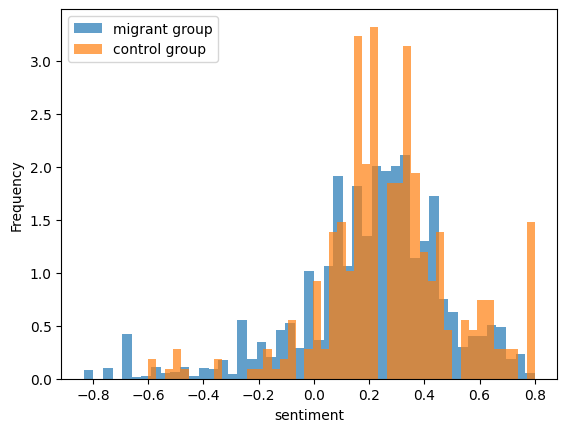

In [7]:
# Visualise data

data = pd.concat([sentiment_control, sentiment_migrants])
n_bins = int((data.max() - data.min()) / (2 * (data.quantile(0.75) - data.quantile(0.25)) / data.count()**(1/3)))  # Freedman-Diaconis rule

sentiment_migrants.plot(kind="hist", bins=n_bins, density=True, alpha=0.7)
sentiment_control.plot(kind="hist", bins=n_bins, density=True, alpha=0.7)
plt.legend(["migrant group", "control group"])
plt.xlabel("sentiment")
plt.show()

In [ ]:
# Test for significance

def analyse_for_permut(words):
    sentiment = svo_tuples.apply(analyse_svo_tuples, wordlist=words).dropna()
    df = pd.DataFrame()
    df["sentiment"] = sentiment
    return df

significance_level=0.05
output=True
test_types = {"sentiment": "less"}

print("Mean difference:", (sentiment_control.mean() - sentiment_migrants.mean()), "\n")
print("Difference in standard deviation:", abs(sentiment_control.std() - sentiment_migrants.std()), "\n")

print("Conducting t-test:")

test = stats.ttest_ind(sentiment_migrants, sentiment_control, alternative="less")
if test.pvalue < significance_level:
    if output: print("\tThere is enough evidence to reject the null hypothesis")
    if output: print("\tt({}) = {}, p = {}\n".format(test.df, test.statistic, test.pvalue))

else:
    if output: print("\tThere is insufficient evidence to reject the null hypothesis", "(p: {})".format(test.pvalue))

data_analysis.permutation_test_difference(target_groups, control_groups, test_types, function=analyse_for_permut, n=1000)

Mean difference: 0.06831828219304148 

Difference in standard deviation: 0.031941226176886856 

Conducting t-test:
	There is enough evidence to reject the null hypothesis
	t(3799.0) = -4.602081995039253, p = 2.15975544837309e-06
Conducting permutation test:
	There is insufficient evidence to reject the null hypothesis for sentiment (p: 0.143)


[0]

In [ ]:
# Get size of data

print(len(svo_tuples))
len(sentiment_migrants), len(sentiment_control)

157574


(3437, 364)